# Bacterial Promoter Classification - Comparison to Kh. et al.

This notebook details comparisons of promoter classification results between the Genomic-ULMFiT method and the method used in [Recognition of prokaryotic and eukaryotic promoters using convolutional deep learning neural networks](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0171410)

### Method Differences

The Genomic-ULMFiT method used an RNN architecture based on the AWD-LSTM model. The model is trained on three stages:
  1. Train a genomic language model on a large general corpus (the bacterial genome ensemble)
  2. Fine tune the language model on the classification corpus (the promoter dataset)
  3. Train the classification model
Within the RNN, nucleotide sequences are represented as 5bp k-mers with a stride of 2 between k-mers. This gives the model a vocabulary of 1025 "words" (1024 genomic sequences + 1 padding token). I believe k-mer modeling of sequences gives a richer representation compared to looking at single nucleotides.

Kh. et al. used a convolutional model. Nucleotides are treated as single ATGC nucleotides represented by one hot encoded vectors. The convolutional model consisted of a single convolutional layer followed by a max pooling and a linear layer for classification.

### Data Sources

The genomic language model used in this notebook is the one trained in [Bacterial Ensemble 1 Language Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/Bacterial%20Ensemble/Bacterial%20Ensemble%201%20Language%20Model.ipynb). The classification data will be the same data used by Kh. et al., available from this [repo](https://github.com/solovictor/CNNPromoterData). This notebook will look at data for E. coli and B. subtilis. 

Kh. et al. also applied their methods to human promoter sequences. The results comparing Genomic-ULMFit to Kh. et al. can be found in the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Human%204%20Short%20Promoter%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

### Summary of Results

| E. coli Results 	| Training Examples 	| Accuracy 	| Precision 	| Recall 	| Correlation Coefficient 	| Specificity 	|
|-----------------	|-------------------	|----------	|-----------	|--------	|-------------------------	|-------------	|
| Kh. et al.      	|        2936       	|     -    	|     -     	|  __0.90__  	|           0.84          	|     0.96    	|
| Genomic-ULMFiT  	|        2936       	|   0.956  	|   0.917   	|  0.880 	|          __0.871__          	|    __0.977__    	|

| B. subtilis Results 	| Training Examples 	| Accuracy 	| Precision 	| Recall 	| Correlation Coefficient 	| Specificity 	|
|---------------------	|-------------------	|----------	|-----------	|--------	|-------------------------	|-------------	|
| Kh. et al.          	|        1050       	|     -    	|     -     	|  __0.91__  	|           __0.86__          	|     0.95    	|
| Genomic-ULMFiT      	|        1050       	|   0.905  	|   0.857   	|  0.789 	|          0.759          	|     0.95    	|

This result confirms a general intuition about CNN vs LSTM architectures - CNNs are more performant when data is limited. Additionally the source data was made up of small 81 bp sequences. With such short sequences, I expect CNNs to do better as there are no long term dependencies across such short sequences. I would expect LSTM/Genomic-ULMFiT methods to be more performant over longer sequences. However it seems with as few as 3000 labeled examples, LSTM based methods can reach comprable or superior performance to CNNs. I think this shows the advantage of using transfer learning and training on large, general genomic corpuses. I expect training a LSTM from scratch on such a small dataset would have produced much worse results.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# E. coli Promoters

Rather than use the E. coli promoter corpus assembled in the [E. coli](https://github.com/kheyer/Genomic-ULMFiT/tree/master/Bacteria/E.%20Coli) section of this repo, we will use the same data used by Kh. et al.

In [5]:
fname1 = 'Ecoli_prom.fa'
fname2 = 'Ecoli_non_prom.fa'

In [6]:
fasta1 = SeqIO.parse(path/fname1, 'fasta')
seqs1 = [i.seq.__str__() for i in fasta1 if set(i.seq.__str__().upper()) == set('ATGC')]
seq1_df = pd.DataFrame(seqs1, columns=['Sequence'])
seq1_df['Promoter'] = 1

In [7]:
fasta2 = SeqIO.parse(path/fname2, 'fasta')
seqs2 = [i.seq.__str__() for i in fasta2 if set(i.seq.__str__().upper()) == set('ATGC')]
seq2_df = pd.DataFrame(seqs2, columns=['Sequence'])
seq2_df['Promoter'] = 0

In [8]:
seq1_df.shape, seq2_df.shape

((839, 2), (3000, 2))

In [9]:
seq1_df.drop_duplicates(inplace=True)
seq2_df.drop_duplicates(inplace=True)

In [10]:
seq1_df.shape, seq2_df.shape

((839, 2), (3000, 2))

In [11]:
def partition_data(df):
    
    train_size = int(len(df)*0.85*.9)
    valid_size = int(len(df)*0.85) - train_size
    
    train_df = df.sample(train_size)
    test_val = df.drop(train_df.index)
    valid_df = test_val.sample(valid_size)
    test_df = test_val.drop(valid_df.index)
    train_df['set'] = 'train'
    valid_df['set'] = 'valid'
    test_df['set'] = 'test'
    
    return (train_df, valid_df, test_df)

In [12]:
t1, v1, test1 = partition_data(seq1_df)
t2, v2, test2 = partition_data(seq2_df)
data_df = pd.concat([t1,t2,v1,v2,test1,test2])

In [13]:
data_df[data_df.set == 'train'].shape, data_df[data_df.set == 'valid'].shape, data_df[data_df.set == 'test'].shape, data_df.shape

((2936, 3), (327, 3), (576, 3), (3839, 3))

In [14]:
data_df.to_csv(path/'coli_promoters_short.csv', index=False)

# LM Fine Tune

Here we create a language model corpus from our classification dataset. This basically concatenates all our promoter sequences into a single long string of text. The language model is trained on the concatenated promoter corpus. We need to make sure to create our dataloader with the correct vocabulary.

In [15]:
classification_df = pd.read_csv(path/'coli_promoters_short.csv')

In [16]:
classification_df.head()

,Sequence,Promoter,set
0,GTTGATACAATGCGATAAAATTGCCCTTGCGAAGGTCATTCGCTTT...,1,train
1,TGGCTAACGCCTCAATGAATTAAAATTCAATTTATATGGATGATTA...,1,train
2,TTACCCGACGTTGTAATCCAACATTGCGAGCGGCGTAAAGCCGCCG...,1,train
3,CTGATGAATTGAAGATTCATCTGGTTGAATATGTGCCGATTGCGCG...,1,train
4,GACAAATATTGATAGCCTGAATCAGTATTGATCTGCTGGCAAGAAC...,1,train


In [17]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [18]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [19]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [20]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Promoter', vocab=model_vocab)

In [23]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.4

In [24]:
learn = get_model_LM(data, drop_mult, config)

We initialize the model by loading the weights from the bacterial genome ensemble language model

In [25]:
learn.load('b2');

In [26]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


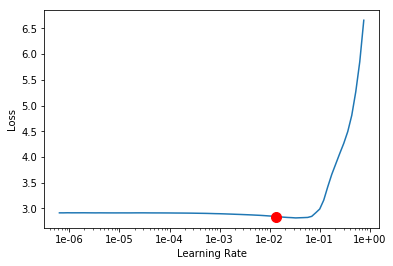

In [30]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(15, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.913399,2.882303,0.141179
2,2.893576,2.827886,0.147821
3,2.871529,2.797442,0.152179
4,2.850202,2.789649,0.154536
5,2.828844,2.783352,0.157536
6,2.806226,2.778952,0.157500
7,2.780853,2.779397,0.158750
8,2.755099,2.788126,0.159750
9,2.729330,2.776970,0.165036
10,2.700737,2.787564,0.164571


In [29]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.461228,2.785201,0.169857
2,2.453898,2.789583,0.170786
3,2.448290,2.789180,0.171857
4,2.440798,2.797045,0.171964
5,2.429855,2.793729,0.173286
6,2.416066,2.808968,0.174964
7,2.404983,2.804299,0.176786
8,2.389329,2.806546,0.177286
9,2.374428,2.806811,0.179429
10,2.360042,2.810378,0.179429


In [30]:
learn.save('bact_coli_finetune')
learn.save_encoder('bact_coli_finetune_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'coli_promoters_short.csv')

In [6]:
classification_df.head()

,Sequence,Promoter,set
0,GTTGATACAATGCGATAAAATTGCCCTTGCGAAGGTCATTCGCTTT...,1,train
1,TGGCTAACGCCTCAATGAATTAAAATTCAATTTATATGGATGATTA...,1,train
2,TTACCCGACGTTGTAATCCAACATTGCGAGCGGCGTAAAGCCGCCG...,1,train
3,CTGATGAATTGAAGATTCATCTGGTTGAATATGTGCCGATTGCGCG...,1,train
4,GACAAATATTGATAGCCTGAATCAGTATTGATCTGCTGGCAAGAAC...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [15]:
learn.load_encoder('bact_coli_finetune_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


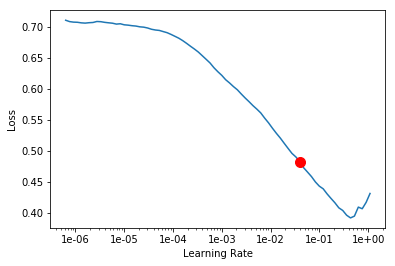

In [16]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.500534,0.532185,0.779817
2,0.372984,0.636757,0.779817
3,0.308850,0.613706,0.779817
4,0.272136,0.595945,0.779817


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.173242,0.478516,0.779817
2,0.170778,0.365383,0.807339
3,0.159573,0.372323,0.801223
4,0.150200,0.276739,0.859327


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.126004,0.219165,0.908257
2,0.115253,0.211218,0.917431
3,0.110808,0.164283,0.944954
4,0.107112,0.158159,0.948012


In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.089394,0.151150,0.957187
2,0.088787,0.151560,0.954128
3,0.088269,0.160756,0.957187
4,0.080922,0.164385,0.957187


In [20]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.067500,0.164583,0.957187
2,0.067827,0.163399,0.960245
3,0.067059,0.163668,0.957187
4,0.066771,0.164866,0.957187


In [21]:
learn.fit_one_cycle(4, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.057958,0.164913,0.957187
2,0.060759,0.164110,0.957187
3,0.063413,0.165636,0.957187
4,0.061622,0.164694,0.960245


In [22]:
learn.save('coli_short_bact_pretrain_finetune')

In [23]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

In [24]:
get_scores(learn)

Accuracy: 0.9565972222222222
False Positives: 0.017361111111111112
False Negatives: 0.026041666666666668
Recall: 0.8809523809523809
Precision: 0.9173553719008265
Specificity: 0.9777777777777777
MCC: 0.8714648235423607


# B. subtilis Promoters

In [5]:
fname1 = 'Bacillus_prom.fa'
fname2 = 'Bacillus_non_prom.fa'

In [6]:
fasta1 = SeqIO.parse(path/fname1, 'fasta')
seqs1 = [i.seq.__str__() for i in fasta1 if set(i.seq.__str__().upper()) == set('ATGC')]
seq1_df = pd.DataFrame(seqs1, columns=['Sequence'])
seq1_df['Promoter'] = 1

In [7]:
fasta2 = SeqIO.parse(path/fname2, 'fasta')
seqs2 = [i.seq.__str__() for i in fasta2 if set(i.seq.__str__().upper()) == set('ATGC')]
seq2_df = pd.DataFrame(seqs2, columns=['Sequence'])
seq2_df['Promoter'] = 0

In [8]:
seq1_df.shape, seq2_df.shape

((373, 2), (1000, 2))

In [9]:
seq1_df.drop_duplicates(inplace=True)
seq2_df.drop_duplicates(inplace=True)

In [10]:
seq1_df.shape, seq2_df.shape

((373, 2), (1000, 2))

In [11]:
def partition_data(df):
    
    train_size = int(len(df)*0.9*.85)
    valid_size = int(len(df)*0.9) - train_size
    
    train_df = df.sample(train_size)
    test_val = df.drop(train_df.index)
    valid_df = test_val.sample(valid_size)
    test_df = test_val.drop(valid_df.index)
    train_df['set'] = 'train'
    valid_df['set'] = 'valid'
    test_df['set'] = 'test'
    
    return (train_df, valid_df, test_df)

In [12]:
t1, v1, test1 = partition_data(seq1_df)
t2, v2, test2 = partition_data(seq2_df)
data_df = pd.concat([t1,t2,v1,v2,test1,test2])

In [13]:
data_df[data_df.set == 'train'].shape, data_df[data_df.set == 'valid'].shape, data_df[data_df.set == 'test'].shape, data_df.shape

((1050, 3), (185, 3), (138, 3), (1373, 3))

In [14]:
data_df.to_csv(path/'bac_promoters_short.csv', index=False)

# LM Fine Tune

In [15]:
classification_df = pd.read_csv(path/'bac_promoters_short.csv')

In [16]:
classification_df.head()

,Sequence,Promoter,set
0,AGCAGCTAACCACTTGTTTTGAGCTTGACTTAAAGTTAACTTTAAG...,1,train
1,TCATATAGGAGGCATGATGTGTGCTACTACAAAAGACTTCTCTCAT...,1,train
2,GAGTAAAAAATTTTCAGAAATTTATATTGACTGAAAGCGTTTTTAT...,1,train
3,TAAACGTTTTTTTGGTTAATCTGTCAATGAACTATCATGTTGCTCC...,1,train
4,ACCATGTCAGGAAATCTTACATGAAAATGTTTTATCATTCTTTTTT...,1,train


In [17]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [18]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [19]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [20]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Promoter', vocab=model_vocab)

In [23]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.4

In [24]:
learn = get_model_LM(data, drop_mult, config)

We initialize the model by loading the weights from the bacterial genome ensemble language model

In [25]:
learn.load('b2');

In [26]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


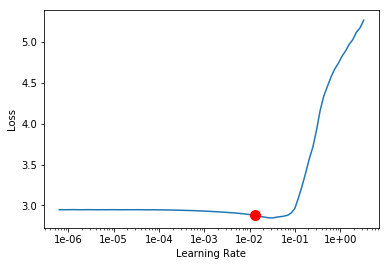

In [45]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(15, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.956155,2.927231,0.134750
2,2.958343,2.897450,0.140143
3,2.937825,2.850604,0.144786
4,2.916670,2.837505,0.146071
5,2.899312,2.829042,0.146250
6,2.882535,2.829808,0.147107
7,2.867793,2.824120,0.149714
8,2.852381,2.819105,0.151464
9,2.837017,2.816441,0.156607
10,2.822505,2.816275,0.158143


In [29]:
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.656941,2.816537,0.161250
2,2.647879,2.816005,0.161750
3,2.634889,2.819366,0.162893
4,2.616961,2.818023,0.164500
5,2.600330,2.821823,0.168393
6,2.577762,2.819679,0.172357
7,2.554667,2.837214,0.176393
8,2.531313,2.820942,0.180071
9,2.510269,2.820665,0.180357
10,2.493707,2.820815,0.180286


In [30]:
learn.save('bact_basc_finetune')
learn.save_encoder('bact_basc_finetune_enc')

# Classification

In [31]:
classification_df = pd.read_csv(path/'bac_promoters_short.csv')

In [32]:
classification_df.head()

,Sequence,Promoter,set
0,AGCAGCTAACCACTTGTTTTGAGCTTGACTTAAAGTTAACTTTAAG...,1,train
1,TCATATAGGAGGCATGATGTGTGCTACTACAAAAGACTTCTCTCAT...,1,train
2,GAGTAAAAAATTTTCAGAAATTTATATTGACTGAAAGCGTTTTTAT...,1,train
3,TAAACGTTTTTTTGGTTAATCTGTCAATGAACTATCATGTTGCTCC...,1,train
4,ACCATGTCAGGAAATCTTACATGAAAATGTTTTATCATTCTTTTTT...,1,train


In [33]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [34]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [35]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)

In [56]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.7

In [57]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [58]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.27999999999999997)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [59]:
learn.load_encoder('bact_basc_finetune_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


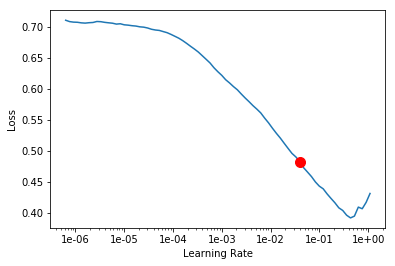

In [16]:
learn.lr_find()
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(4, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.689509,0.612251,0.729730
2,0.575018,0.561112,0.729730
3,0.514595,0.566621,0.729730
4,0.480640,0.567004,0.729730


In [61]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.385732,0.561804,0.729730
2,0.367839,0.560136,0.729730
3,0.354993,0.565927,0.729730
4,0.336612,0.564908,0.729730


In [62]:
learn.freeze_to(-3)
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.300754,0.556508,0.729730
2,0.305087,0.570803,0.729730
3,0.301535,0.581409,0.729730
4,0.294301,0.590925,0.729730
5,0.289034,0.582832,0.729730
6,0.285933,0.564587,0.729730
7,0.280594,0.533432,0.729730
8,0.278057,0.509486,0.729730


In [63]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.237294,0.488867,0.735135
2,0.250103,0.463204,0.745946
3,0.240762,0.474512,0.756757
4,0.233077,0.437733,0.767568
5,0.237445,0.378379,0.794595
6,0.231577,0.355608,0.810811
7,0.226700,0.339119,0.816216
8,0.222970,0.320593,0.837838


In [64]:
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.224602,0.308513,0.854054
2,0.221009,0.296197,0.859459
3,0.218233,0.282124,0.864865
4,0.218931,0.267262,0.864865
5,0.217462,0.261889,0.870270
6,0.218179,0.254938,0.881081
7,0.214846,0.247385,0.881081
8,0.210975,0.241078,0.891892
9,0.210366,0.235561,0.897297
10,0.209049,0.230881,0.891892


In [65]:
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.181526,0.220997,0.897297
2,0.181852,0.222813,0.886487
3,0.183115,0.224220,0.891892
4,0.189784,0.221727,0.891892
5,0.193925,0.221928,0.891892
6,0.191808,0.223832,0.891892
7,0.189671,0.228597,0.886487
8,0.189607,0.229924,0.886487
9,0.190209,0.228295,0.886487
10,0.189034,0.226587,0.881081


In [66]:
learn.fit_one_cycle(15, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.182414,0.228264,0.897297
2,0.178554,0.227628,0.897297
3,0.174819,0.229648,0.897297
4,0.177693,0.230079,0.897297
5,0.179033,0.230748,0.897297
6,0.181122,0.230243,0.897297
7,0.179588,0.230890,0.897297
8,0.178784,0.230972,0.891892
9,0.180475,0.229081,0.897297
10,0.179370,0.228742,0.897297


In [67]:
learn.save('bac_short_bact_pretrain_finetune')

In [68]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

In [69]:
get_scores(learn)

Accuracy: 0.9057971014492754
False Positives: 0.036231884057971016
False Negatives: 0.057971014492753624
Recall: 0.7894736842105263
Precision: 0.8571428571428571
Specificity: 0.95
MCC: 0.7592099427741285
